In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.utils import shuffle
import cv2
from tqdm.notebook import tqdm
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix

In [3]:
#loading data
test_data_path= '/kaggle/input/malaria-dataset2/cell_images'
classes = ['Parasitized','Uninfected']
images = []
labels = []
for i, class_name in enumerate(classes):
    folder_name = f"{i}"
    folder_path = os.path.join(test_data_path, class_name)
    if os.path.isdir(folder_path):
        print(f'Loading category: {class_name}')
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)

            if img is not None:
                img = cv2.resize(img, (150, 150))
                images.append(img)
                labels.append(i)


X= np.array(images)
y= np.array(labels)
X, y=shuffle(X, y, random_state=42)
print("Loaded images shape:", X.shape)
print("Loaded labels shape:", y.shape)

Loading category: Parasitized
Loading category: Uninfected
Loaded images shape: (27558, 150, 150, 3)
Loaded labels shape: (27558,)


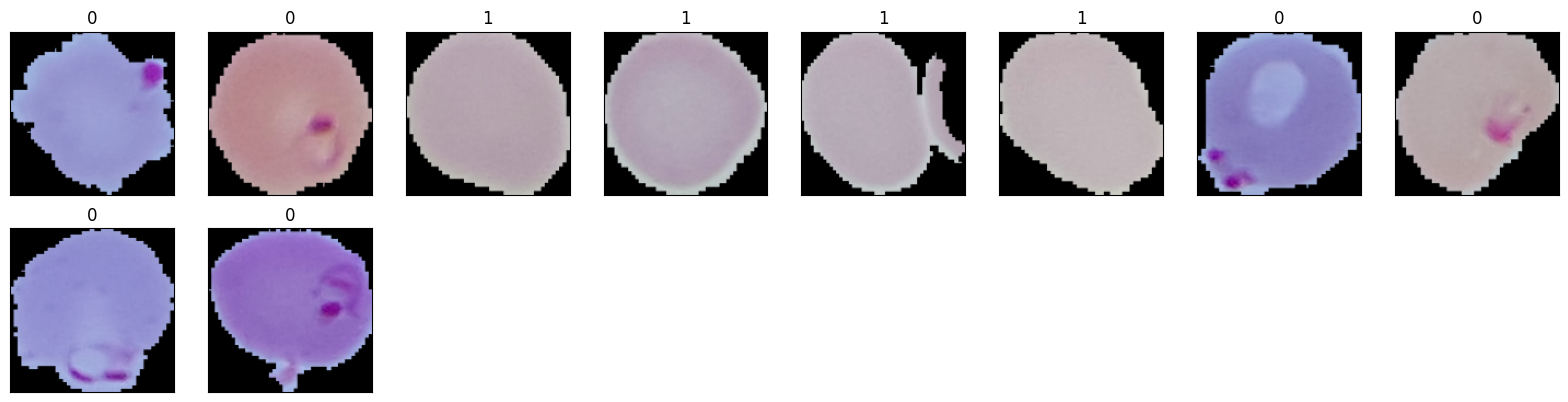

In [4]:
#show 10 cell images  
plt.figure(figsize=(20,20))
for i in range(10):
  plt.subplot(8, 8, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X[i])
  plt.title(y[i])
plt.show()

In [5]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [6]:
print(f"X_train shape {X_train.shape}")
print(f"X_test shape {X_test.shape}")

X_train shape (22046, 150, 150, 3)
X_test shape (5512, 150, 150, 3)


In [7]:
#convert the training labels to float type and apply normalization
datagen1=ImageDataGenerator(rescale=1/255.0)
train_datagen=datagen1.flow(X_train,y_train, batch_size=8)
test_datagen=datagen1.flow(X_test,y_test, batch_size=8)

In [8]:
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

In [9]:
width = 150
height = 150
trainDatagen = datagen.flow_from_directory(directory='/kaggle/input/malaria-dataset2/cell_images',
                                           target_size=(width,height),
                                           class_mode = 'binary',
                                           batch_size = 16,
                                           subset='training')

Found 22048 images belonging to 2 classes.


In [9]:
width = 150
height = 150
valDatagen = datagen.flow_from_directory(directory='/kaggle/input/malaria-dataset2/cell_images',
                                           target_size=(width,height),
                                           class_mode = 'binary',
                                           batch_size = 16,
                                           subset='validation')

Found 5510 images belonging to 2 classes.


In [10]:
#hyperparameters
epochs=100
batch_size=64
#learning rate scheduler
scheduler=tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    alpha=0.001,
    decay_steps=5000
)
#SGD
optimizer=tf.keras.optimizers.SGD(
    learning_rate=scheduler,
    momentum=0.0
)
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [11]:
def custom_resnet(input_shape):
    input_img = layers.Input(shape=input_shape)

    # Initial convolutional layer
    Z1 = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same')(input_img)
    BN1 = layers.BatchNormalization()(Z1)
    A1 = layers.ReLU()(BN1)

    #First residual block
    Z2 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(A1)
    BN2 = layers.BatchNormalization()(Z2)
    A2 = layers.ReLU()(BN2)
    Z3 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(A2)
    BN3 = layers.BatchNormalization()(Z3)
    shortcut1 = layers.Conv2D(filters=64, kernel_size=(1, 1), padding='same')(A1) 
    R1 = layers.Add()([BN3, shortcut1])
    A3 = layers.ReLU()(R1)

    # Second residual block
    Z4 = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding='same')(A3) 
    BN4 = layers.BatchNormalization()(Z4)
    A4 = layers.ReLU()(BN4)
    Z5 = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')(A4)
    BN5 = layers.BatchNormalization()(Z5)
    shortcut2 = layers.Conv2D(filters=128, kernel_size=(1, 1), strides=2, padding='same')(A3) 
    R2 = layers.Add()([BN5, shortcut2])
    A5 = layers.ReLU()(R2)

    #Third residual block
    Z6 = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding='same')(A5)  
    BN6 = layers.BatchNormalization()(Z6)
    A6 = layers.ReLU()(BN6)
    Z7 = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same')(A6)
    BN7 = layers.BatchNormalization()(Z7)
    shortcut3 = layers.Conv2D(filters=256, kernel_size=(1, 1), strides=2, padding='same')(A5)
    R3 = layers.Add()([BN7, shortcut3])
    A7 = layers.ReLU()(R3)
    
    GAP = layers.GlobalAveragePooling2D()(A7)
    dense1 = layers.Dense(512, activation='relu')(GAP)
    dropout = layers.Dropout(0.5)(dense1)
    outputs = layers.Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=input_img, outputs=outputs)
    return model
input_shape = (150, 150, 3) 
resnet = custom_resnet(input_shape)
resnet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 150, 150,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 150, 150,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 150, 150,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 150, 150,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 150, 150,  │      4,160 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 150, 150,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 150, 150,  │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │     73,856 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 75, 75,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 75, 75,    │    147,584 │ re_lu_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        512 │ conv2d_5[0][0]  

 Total params: 1,363,777 (5.20 MB)

 Trainable params: 1,361,857 (5.20 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [18]:
resnet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history1=resnet.fit(X_train,y_train,
                       batch_size=32,
                       epochs=100,
                       validation_data=(X_test,y_test),
                       #callbacks=[early_stop]
                       )

Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 100s 131ms/step - accuracy: 0.9639 - loss: 0.1067 - val_accuracy: 0.9614 - val_loss: 0.1021
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 86s 125ms/step - accuracy: 0.9624 - loss: 0.1089 - val_accuracy: 0.9612 - val_loss: 0.1022
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 86s 125ms/step - accuracy: 0.9648 - loss: 0.1016 - val_accuracy: 0.9614 - val_loss: 0.1020
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 86s 125ms/step - accuracy: 0.9633 - loss: 0.1046 - val_accuracy: 0.9610 - val_loss: 0.1021
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 86s 125ms/step - accuracy: 0.9630 - loss: 0.1036 - val_accuracy: 0.9612 - val_loss: 0.1023
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 86s 125ms/step - accuracy: 0.9635 - loss: 0.1037 - val_accuracy: 0.9617 - val_loss: 0.1016
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 86s 125ms/step - accuracy: 0.9624 - loss: 0.1092 - val_accuracy: 0.9608 - val_loss: 0.1019
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 86s 125ms/step - accuracy: 0.9627 

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

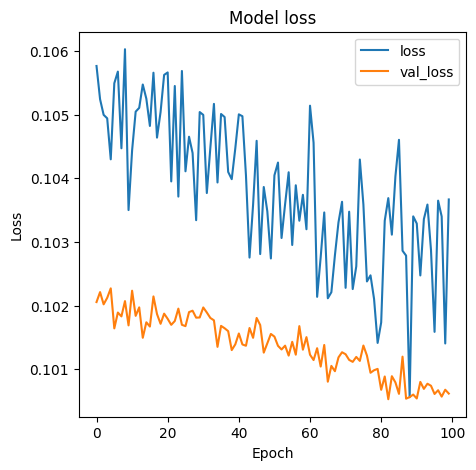

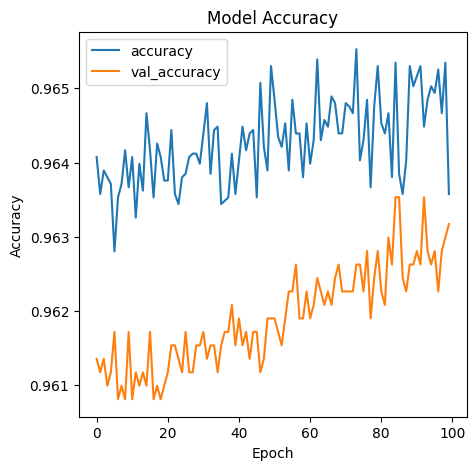

In [19]:
df_loss_acc = pd.DataFrame(history1.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train loss','val_loss':'validation loss'})
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train loss','val_accuracy':'validation loss'})
df_loss.plot(title='Model loss',figsize=(5,5)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(5,5)).set(xlabel='Epoch',ylabel='Accuracy')


In [20]:
y_pred1=resnet.predict(X_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step


In [22]:
y_pred_classes = (y_pred1.ravel() > 0.5).astype(int)

In [24]:
labels=['Parasitized','Uninfected']
print(classification_report(y_test, y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2799
  Uninfected       0.95      0.97      0.96      2713

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



<Figure size 500x500 with 0 Axes>

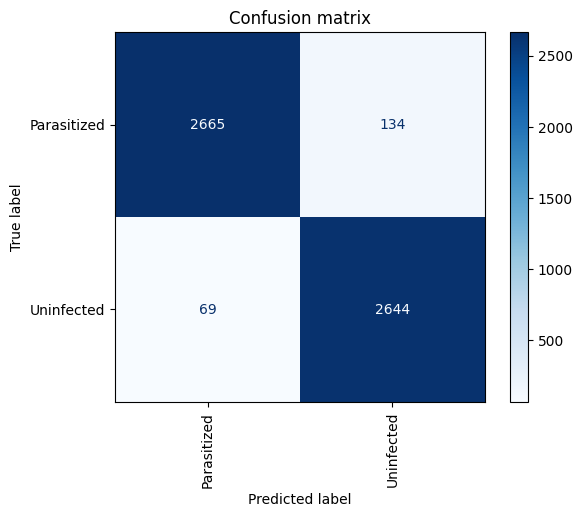

              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2799
  Uninfected       0.95      0.97      0.96      2713

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



In [39]:
cm = confusion_matrix(y_test, y_pred_classes)
labels=['Parasitized','Uninfected']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion matrix")
plt.show()
print(classification_report(y_test, y_pred_classes, target_names=labels))

In [43]:
#Resnet with Early Stopping
#learning rate scheduler
scheduler=tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    alpha=0.001,
    decay_steps=1000
)
#SGD
optimizer=tf.keras.optimizers.Adam(
    learning_rate=scheduler
)
early_stop = EarlyStopping(monitor='val_loss',patience=2)
resnet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history2=resnet.fit(X_train,y_train,
                       batch_size=32,
                       epochs=30,
                       validation_data=(X_test,y_test),
                       callbacks=[early_stop]
                       )

Epoch 1/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 102s 134ms/step - accuracy: 0.7821 - loss: 4.1017 - val_accuracy: 0.9383 - val_loss: 0.2450
Epoch 2/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 87s 126ms/step - accuracy: 0.9403 - loss: 0.2226 - val_accuracy: 0.9387 - val_loss: 0.2088
Epoch 3/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 87s 126ms/step - accuracy: 0.9401 - loss: 0.2136 - val_accuracy: 0.9387 - val_loss: 0.2082
Epoch 4/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 87s 126ms/step - accuracy: 0.9407 - loss: 0.2143 - val_accuracy: 0.9392 - val_loss: 0.2079
Epoch 5/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 87s 126ms/step - accuracy: 0.9440 - loss: 0.2075 - val_accuracy: 0.9399 - val_loss: 0.2075
Epoch 6/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 87s 126ms/step - accuracy: 0.9415 - loss: 0.2158 - val_accuracy: 0.9399 - val_loss: 0.2067
Epoch 7/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 87s 126ms/step - accuracy: 0.9430 - loss: 0.2147 - val_accuracy: 0.9409 - val_loss: 0.2055
Epoch 8/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 87s 126ms/step - accuracy: 0.9451 - loss: 

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

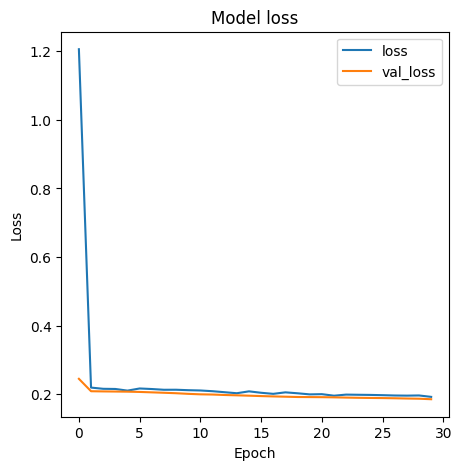

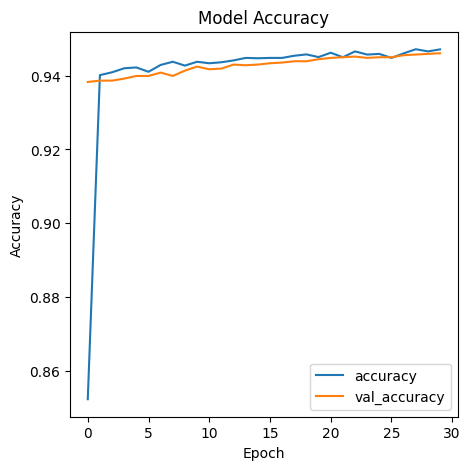

In [46]:
df_loss_acc = pd.DataFrame(history2.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train loss','val_loss':'validation loss'})
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train loss','val_accuracy':'validation loss'})
df_loss.plot(title='Model loss',figsize=(5,5)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(5,5)).set(xlabel='Epoch',ylabel='Accuracy')


In [47]:
y_pred2=resnet.predict(X_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


In [48]:
y_pred_classes = (y_pred2.ravel() > 0.5).astype(int)
labels=['Parasitized','Uninfected']
print(classification_report(y_test, y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

 Parasitized       0.97      0.93      0.95      2799
  Uninfected       0.93      0.97      0.95      2713

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



<Figure size 500x500 with 0 Axes>

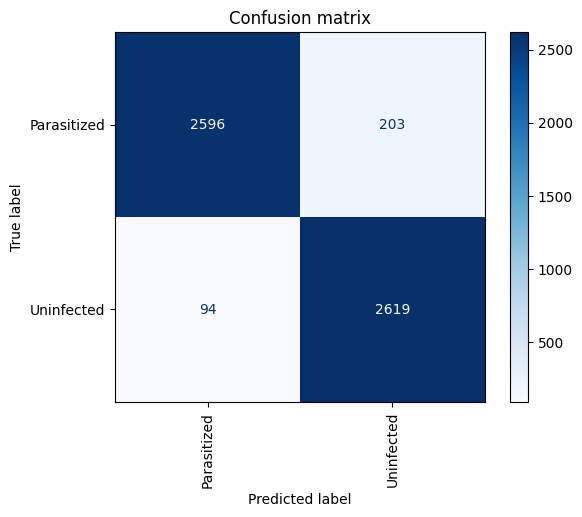

In [49]:
cm = confusion_matrix(y_test, y_pred_classes)
labels=['Parasitized','Uninfected']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion matrix")
plt.show()

In [13]:
#Transfer Learning using Xception
base_model=tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
)
base_model.trainable=False

def tf_model(input_shape):
    img_input=layers.Input(shape=input_shape)
    x= base_model(img_input,training=False)
    x= layers.GlobalAveragePooling2D()(x)
    x=layers.Dense(512, activation='relu')(x)
    outputs=layers.Dense(1,activation='sigmoid')(x)
    model=Model(inputs=img_input,outputs=outputs)
    return model



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [19]:
transfer_model=tf_model((150,150,3))
early_stop = EarlyStopping(monitor='val_loss',patience=5)
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
history1=transfer_model.fit(train_datagen, epochs=30,validation_data=test_datagen,
                           callbacks=[early_stop]
                           )

Epoch 1/30
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 57s 19ms/step - binary_accuracy: 0.9165 - loss: 0.2213 - val_binary_accuracy: 0.9296 - val_loss: 0.1733
Epoch 2/30
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - binary_accuracy: 0.9394 - loss: 0.1636 - val_binary_accuracy: 0.9292 - val_loss: 0.1879
Epoch 3/30
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - binary_accuracy: 0.9465 - loss: 0.1419 - val_binary_accuracy: 0.9387 - val_loss: 0.1537
Epoch 4/30
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - binary_accuracy: 0.9514 - loss: 0.1309 - val_binary_accuracy: 0.9380 - val_loss: 0.1550
Epoch 5/30
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - binary_accuracy: 0.9557 - loss: 0.1232 - val_binary_accuracy: 0.9390 - val_loss: 0.1542
Epoch 6/30
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - binary_accuracy: 0.9560 - loss: 0.1125 - val_binary_accuracy: 0.9389 - val_loss: 0.1613
Epoch 7/30
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - binary_accuracy: 0.9581 - loss: 0.1056 - val_binary_accuracy: 0.93

In [20]:
y_pred3=transfer_model.predict(X_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step


In [21]:
y_pred_classes = (y_pred3.ravel() > 0.5).astype(int)
labels=['Parasitized','Uninfected']
print(classification_report(y_test, y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

 Parasitized       0.51      0.96      0.66      2799
  Uninfected       0.48      0.04      0.07      2713

    accuracy                           0.51      5512
   macro avg       0.49      0.50      0.37      5512
weighted avg       0.49      0.51      0.37      5512

